In [1]:
import numpy as np
import pandas as pd
import torch
import re
from transformers import RobertaTokenizerFast, RobertaForTokenClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from gensim.utils import tokenize

In [2]:
file_path = "/kaggle/input/generated-mountain-entity-recognition-dataset/mountain_sentences_ner.csv"
df = pd.read_csv(file_path)
df.fillna({'entity': 'NoEntity', 'start_idx': -1, 'end_idx': -1}, inplace=True)

df.head()

,original_sentence,new_sentence,entity,start_idx,end_idx
0,The mountains are a lush green in summer.,The Mount Kilimanjaro are a lush green in summer.,Mount Kilimanjaro,4.0,21.0
1,Mountain bike racing has caught on with young ...,Mountain bike racing has caught on with young ...,NoEntity,-1.0,-1.0
2,There are colossal mountains in the north.,There are colossal Makalu in the north.,Makalu,19.0,25.0
3,We are going to the mountains.,We are going to the Mount Aconcagua.,Mount Aconcagua,20.0,35.0
4,Mt. Everest is higher than any other mountain ...,Mt. Everest is higher than any other Pico de O...,Pico de Orizaba,37.0,52.0


In [3]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
def label_entities(sentence, entity, start, end):
    tokenize_sentence = sentence.lower().split()
    entity = entity.lower().split()
    entity_label = [0] * len(tokenize_sentence)
    
    for i, token in  enumerate(tokenize_sentence):
        start_idx = sentence.lower().find(token.lower())
        end_idx = start_idx + len(token) - 1
        
        # if index of token between defined positions than it's mountain
        if (start <= start_idx <= end and start <= end_idx <= end):
            entity_label[i] = 1

    return tokenize_sentence, entity_label

train_data = [label_entities(row['new_sentence'], 
                             row['entity'], int(row['start_idx']), 
                             int(row['end_idx'])) for _, row in train_df.iterrows()]
val_data = [label_entities(row['new_sentence'], 
                           row['entity'], int(row['start_idx']), 
                           int(row['end_idx'])) for _, row in val_df.iterrows()]

In [5]:
train_data[:5]

[(['we', 'watched', 'the', 'sun', 'setting', 'behind', 'the', 'mountains.'],
  [0, 0, 0, 0, 0, 0, 0, 0]),
 (['i',
   'think',
   "it's",
   'dangerous',
   'to',
   'climb',
   'that',
   'denali',
   'alone.'],
  [0, 0, 0, 0, 0, 0, 0, 1, 0]),
 (['the', 'annapurna', 'are', 'reflected', 'in', 'the', 'lake.'],
  [0, 1, 0, 0, 0, 0, 0]),
 (['everest', 'is', 'the', 'highest', 'mountain', 'in', 'the', 'world.'],
  [0, 0, 0, 0, 0, 0, 0, 0]),
 (['some',
   'people',
   'like',
   'the',
   'sea;',
   'others',
   'prefer',
   'the',
   'dhqaulagiri.'],
  [0, 0, 0, 0, 0, 0, 0, 0, 1])]

In [6]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base", add_prefix_space=True)

def tokenize_and_pad(data):
    sentences, labels = zip(*data)
    tokenized_inputs = tokenizer(sentences, padding="max_length", truncation=True, return_tensors="pt", is_split_into_words=True)
    max_seq_length = 512
    
    input_ids = tokenized_inputs["input_ids"]
    attention_masks = tokenized_inputs["attention_mask"]
    
    padded_labels = []
    for label in labels:
        if len(label) < max_seq_length:
            label = label + [0] * (max_seq_length - len(label))
        elif len(label) > max_seq_length:
            label = label[:max_seq_length]
        padded_labels.append(label)
    
    labels = torch.tensor(padded_labels)

    return input_ids, attention_masks, labels

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
train_input_ids, train_attention_masks, train_labels = tokenize_and_pad(train_data)
val_input_ids, val_attention_masks, val_labels = tokenize_and_pad(val_data)

In [8]:
batch_size = 16

train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [9]:
model = RobertaForTokenClassification.from_pretrained(
    "roberta-base",
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)


optimizer = AdamW(model.parameters(), lr=5e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
            

In [10]:
num_epochs = 4

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in train_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {avg_train_loss:.4f}")

    model.eval()
    total_val_loss = 0

    for batch in val_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        total_val_loss += loss.item()
        
    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs} | Validation Loss: {avg_val_loss:.4f}")

Epoch 1/4 | Train Loss: 0.0240
Epoch 1/4 | Validation Loss: 0.0035
Epoch 2/4 | Train Loss: 0.0030
Epoch 2/4 | Validation Loss: 0.0020
Epoch 3/4 | Train Loss: 0.0017
Epoch 3/4 | Validation Loss: 0.0012
Epoch 4/4 | Train Loss: 0.0011
Epoch 4/4 | Validation Loss: 0.0013


In [11]:
from sklearn.metrics import classification_report

def evaluate_model(model, dataloader):
    model.eval()
    true_labels = []
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(b.to(device) for b in batch)
            b_input_ids, b_input_mask, b_labels = batch

            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs.logits
            
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            
            predictions.append(logits)
            true_labels.append(label_ids)

    flat_predictions = np.concatenate(predictions, axis=0)
    flat_true_labels = np.concatenate(true_labels, axis=0)
5v 
    flat_predictions = np.argmax(flat_predictions, axis=2).flatten()
    flat_true_labels = flat_true_labels.flatten()

    return classification_report(flat_true_labels, flat_predictions, labels=[0,1], zero_division=1)


report = evaluate_model(model, val_dataloader)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    206244
           1       0.90      0.98      0.94       604

    accuracy                           1.00    206848
   macro avg       0.95      0.99      0.97    206848
weighted avg       1.00      1.00      1.00    206848



In [12]:
def get_predictions(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            batch = tuple(b.to(device) for b in batch)
            b_input_ids, b_input_mask, b_labels = batch

            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs.logits
            
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            
            batch_predictions = np.argmax(logits, axis=2).flatten()
            batch_true_labels = label_ids.flatten()

            predictions.extend(batch_predictions)
            true_labels.extend(batch_true_labels)

    return np.array(predictions), np.array(true_labels)


predictions, true_labels = get_predictions(model, val_dataloader)

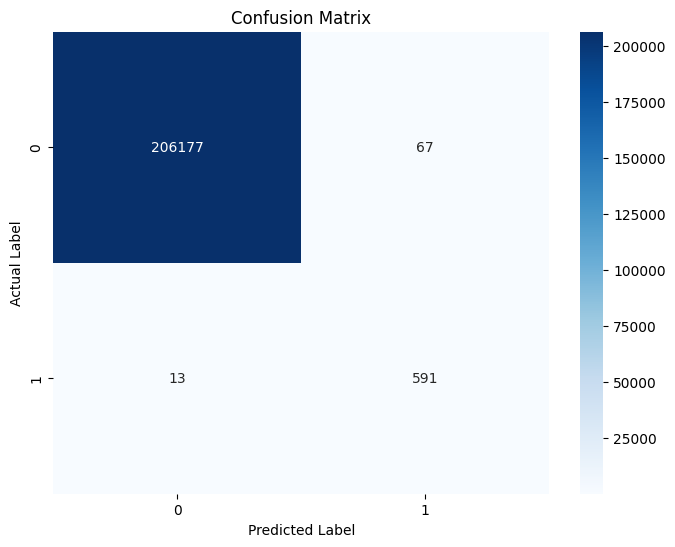

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [14]:
torch.save(model.state_dict(), '/kaggle/working/model_weights.pth')

In [15]:
from IPython.display import FileLink
import shutil
import os

shutil.make_archive('/kaggle/working/model', 'zip', '/kaggle/working', 'model_weights.pth')

'/kaggle/working/model.zip'

In [20]:
import os
os.chdir(r'/kaggle/working')
FileLink('model_weights.pth')


/kaggle/working/model_weights.pth

In [18]:
!ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


model.zip  model_weights.pth  state.db
